In [1]:
import numpy as np
import pandas as pd

from biom import (load_table,
                  Table)
from qiime2 import (Artifact,
                    Metadata, Visualization)
from qiime2.plugins.feature_table.actions import (rarefy)

from qiime2.plugins.gemelli.actions import (rpca)
from qiime2.plugins.mmvec.actions import (paired_omics,
                                          summarize_paired)
from sklearn.model_selection import train_test_split
from skbio import OrdinationResults, DistanceMatrix
from skbio.stats.distance import permanova
from skbio.stats.composition import closure

# plotting
import colorsys
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mc
from matplotlib.pyplot import cm
from matplotlib.colors import to_hex

#plt.style.use('ggplot')
plt.style.use('seaborn') 
%matplotlib inline

def match_all_table_subset(bt1, bt2, bt3, mf, 
                           use_catagory_col,
                           use_catagory_subset,
                           filter_for_strat = None,
                           min_sample_count = 100,
                           min_feature_count = 2,
                           min_feature_samples = 10):
    
    # subset
    mf_subset = mf.copy()[mf[use_catagory_col] == use_catagory_subset]

    # copy and filter
    bt1_subset = bt1.copy()
    bt2_subset = bt2.copy()
    bt3_subset = bt3.copy()
    shared_ids = set(mf_subset.index) & set(bt1_subset.ids()) & set(bt2_subset.ids())  & set(bt3_subset.ids())
    bt1_subset = bt1_subset.filter(shared_ids)
    bt2_subset = bt2_subset.filter(shared_ids)
    bt3_subset = bt3_subset.filter(shared_ids)
    mf_subset = mf_subset.loc[shared_ids, :]
    
    # filter sample to min seq. depth
    def sample_filter(val, id_, md):
        return sum(val) > min_sample_count
    # filter features to min total counts
    def observation_filter(val, id_, md):
        return sum(val) > min_feature_count
    # filter features by N samples presence
    def frequency_filter(val, id_, md):
        return np.sum(val > 0) > min_feature_samples
    
    # filter bt1
    n_features, n_samples = bt1_subset.shape
    bt1_subset = bt1_subset.filter(observation_filter, axis='observation')
    bt1_subset = bt1_subset.filter(frequency_filter, axis='observation')
    bt1_subset = bt1_subset.filter(sample_filter, axis='sample')
    # filter bt2
    n_features, n_samples = bt2_subset.shape
    bt2_subset = bt2_subset.filter(observation_filter, axis='observation')
    bt2_subset = bt2_subset.filter(frequency_filter, axis='observation')
    bt2_subset = bt2_subset.filter(sample_filter, axis='sample')
    # filt bt3
    bt3_subset = bt3_subset.filter(frequency_filter, axis='observation')
    bt3_subset = Table(closure(bt3_subset.matrix_data.toarray().T).T,
                       bt3_subset.ids('observation'),
                       bt3_subset.ids())

    
    # double check all shared
    shared_ids = set(mf_subset.index) & set(bt1_subset.ids()) & set(bt2_subset.ids())  & set(bt3_subset.ids())
    mf_subset = mf_subset.loc[shared_ids, :]
    if filter_for_strat is not None:
        use_catagory_col2_counts = mf_subset[filter_for_strat].value_counts()
        use_catagory_col2_counts = use_catagory_col2_counts[use_catagory_col2_counts > len(use_catagory_col2_counts)].index
        mf_subset = mf_subset[mf_subset[filter_for_strat].isin(use_catagory_col2_counts)]
       
    shared_ids = set(mf_subset.index) & set(bt1_subset.ids()) & set(bt2_subset.ids())
    bt1_subset = bt1_subset.filter(shared_ids)
    bt2_subset = bt2_subset.filter(shared_ids)
    bt3_subset = bt3_subset.filter(shared_ids)
    mf_subset = mf_subset.loc[shared_ids, :]
    # close the data - easier to generalize the mmvec params.
    bt3_subset = Table(closure(bt3_subset.matrix_data.toarray().T).T,
                       bt3_subset.ids('observation'),
                       bt3_subset.ids())
    bt2_subset = Table(closure(bt2_subset.matrix_data.toarray().T).T,
                       bt2_subset.ids('observation'),
                       bt2_subset.ids())
    bt1_subset = Table(closure(bt1_subset.matrix_data.toarray().T).T,
                       bt1_subset.ids('observation'),
                       bt1_subset.ids())

    
    return bt1_subset, bt2_subset, bt3_subset, mf_subset


In [3]:

# import metadata with which to make subsets
allseq_mfdf = pd.read_csv('../data/genus_intersected_with_WIS/metadata_immune_WGS_AllSeqCenters_Primary_Tumor.txt',
                          sep='\t', index_col=0)
seq_centers = allseq_mfdf.data_submitting_center_label.value_counts()
seq_centers = seq_centers[seq_centers > 3]

# import tables w/ all (fungi already agg. bact is not)
fungi_bt = load_table('../data/genus_intersected_with_WIS/immune_rep200_counts_fungi_TCGA_AllSeqCenters_WGS_Primary_Tumor.biom')
fungi_bt = fungi_bt.filter(set(fungi_bt.ids('observation')) - set(['Candida_glabrata']), axis='observation')
bacteria_bt = load_table('../data/genus_intersected_with_WIS/immune_rep200_counts_bacteria_TCGA_AllSeqCenters_WGS_Primary_Tumor.biom')
immune_bt = load_table('../data/genus_intersected_with_WIS/immune_cibersort_rel_abund_TCGA_AllSeqCenters_WGS_Primary_Tumor.biom')

# subset each center
data_subsets = {}
data_subsets_summary = {}
data_subsets_summary_dt = {}
for center_subset in seq_centers.index:
    # make subsets
    
    bt1tmp, bt2tmp, bt3tmp, mftmp = match_all_table_subset(bacteria_bt,
                                                           fungi_bt,
                                                           immune_bt,
                                                           allseq_mfdf.dropna(subset=['disease_type']),
                                                           'data_submitting_center_label',
                                                           center_subset,
                                                           filter_for_strat = 'disease_type')
    # check train cols
    strat_cols = ['disease_type']
    # strat. train/test
    train, test = train_test_split(mftmp, test_size=0.25, random_state=0, 
                                   stratify=mftmp[strat_cols])
    mftmp.loc[:, 'traintest'] = 'Train'
    mftmp.loc[test.index, 'traintest'] = 'Test'
    mftmp.index.name = 'sampleid'
    mftmp = mftmp.drop(['sample_name','PlateCenterFlag'], axis=1)
    # save subset
    data_subsets[center_subset] = (bt1tmp, bt2tmp, bt3tmp, mftmp)
    
    
    data_subsets_summary[center_subset] = {'number bacteria species':data_subsets[center_subset][0].shape[0],
                                           'number fungi species':data_subsets[center_subset][1].shape[0],
                                           'number immune features':data_subsets[center_subset][2].shape[0],
                                           'number of samples':data_subsets[center_subset][3].shape[0]}
    data_subsets_summary_dt[center_subset] = mftmp.disease_type.value_counts()

data_subsets_summary = pd.DataFrame(data_subsets_summary).T
data_subsets_summary.to_csv('../results/tables/mmvec-results-genus/table-information-by-site.csv')
data_subsets_summary


,number bacteria species,number fungi species,number immune features,number of samples
Harvard Medical School,185,41,22,838
Broad Institute of MIT and Harvard,163,19,21,308
Baylor College of Medicine,177,33,20,294
MD Anderson - Institute for Applied Cancer Science,122,24,22,237
Washington University School of Medicine,169,34,19,194


In [4]:
data_subsets_summary_dt = pd.DataFrame(data_subsets_summary_dt).fillna(0)
data_subsets_summary_dt.to_csv('../results/tables/mmvec-results-genus/number-of-samples-disease-type-by-site.csv')
data_subsets_summary_dt


,Harvard Medical School,Broad Institute of MIT and Harvard,Baylor College of Medicine,MD Anderson - Institute for Applied Cancer Science,Washington University School of Medicine
Bladder Urothelial Carcinoma,51.0,27.0,0.0,62.0,0.0
Brain Lower Grade Glioma,51.0,22.0,0.0,0.0,0.0
Breast Invasive Carcinoma,19.0,0.0,0.0,0.0,92.0
Cervical Squamous Cell Carcinoma and Endocervical Adenocarcinoma,0.0,0.0,0.0,43.0,18.0
Colon Adenocarcinoma,73.0,0.0,50.0,0.0,0.0
Esophageal Carcinoma,0.0,0.0,0.0,37.0,0.0
Glioblastoma Multiforme,0.0,28.0,0.0,0.0,0.0
Head and Neck Squamous Cell Carcinoma,85.0,27.0,31.0,21.0,0.0
Kidney Chromophobe,0.0,0.0,49.0,0.0,0.0
Kidney Renal Clear Cell Carcinoma,0.0,0.0,38.0,0.0,0.0


In [5]:
data_subsets_summary_dt_hb = data_subsets_summary_dt[['Harvard Medical School', 'Baylor College of Medicine']]
data_subsets_summary_dt_hb = data_subsets_summary_dt_hb[data_subsets_summary_dt_hb.sum(1) > 0] 
data_subsets_summary_dt_hb



,Harvard Medical School,Baylor College of Medicine
Bladder Urothelial Carcinoma,51.0,0.0
Brain Lower Grade Glioma,51.0,0.0
Breast Invasive Carcinoma,19.0,0.0
Colon Adenocarcinoma,73.0,50.0
Head and Neck Squamous Cell Carcinoma,85.0,31.0
Kidney Chromophobe,0.0,49.0
Kidney Renal Clear Cell Carcinoma,0.0,38.0
Kidney Renal Papillary Cell Carcinoma,0.0,37.0
Liver Hepatocellular Carcinoma,0.0,52.0
Lung Adenocarcinoma,118.0,0.0


In [6]:
data_subsets_summary_dt_hb[data_subsets_summary_dt_hb.astype(bool).sum(1) == 2]


,Harvard Medical School,Baylor College of Medicine
Colon Adenocarcinoma,73.0,50.0
Head and Neck Squamous Cell Carcinoma,85.0,31.0
Rectum Adenocarcinoma,35.0,18.0


In [7]:
data_subsets_summary_dt.astype(bool).sum(0)

Harvard Medical School                                12
Broad Institute of MIT and Harvard                    10
Baylor College of Medicine                             8
MD Anderson - Institute for Applied Cancer Science     6
Washington University School of Medicine               4
dtype: int64

## MMvec per subset

('bacteria-fungi', 'Harvard Medical School')
209
1247


100%|██████████| 179836/179836 [04:26<00:00, 674.80it/s] 


[0.3880332492232811]


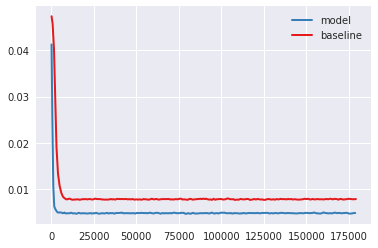

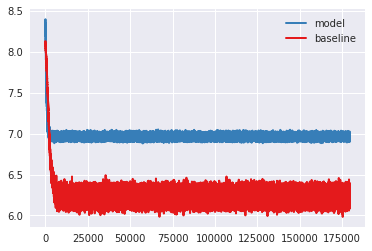

('fungi-bacteria', 'Harvard Medical School')
209
1247


100%|██████████| 37714/37714 [00:54<00:00, 686.76it/s]


[0.14796674177447655]


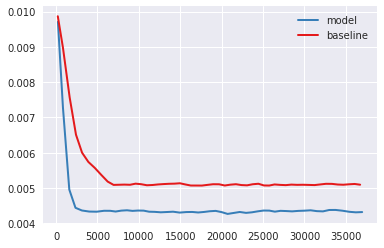

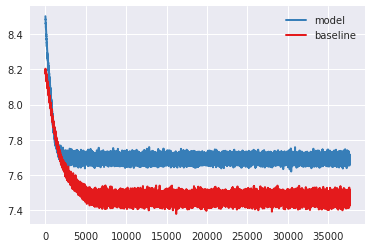

('immune-bacteria', 'Harvard Medical School')
209
498


100%|██████████| 18568/18568 [00:28<00:00, 662.96it/s]


[0.04047490356513472]


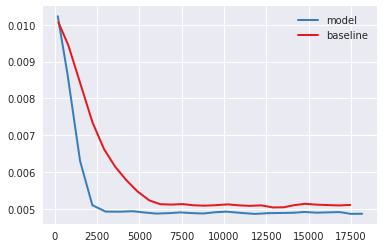

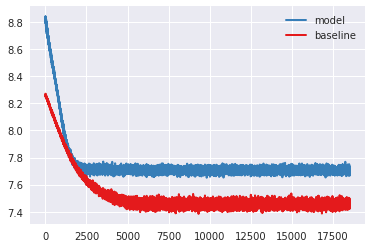

('immune-fungi', 'Harvard Medical School')
209
498


100%|██████████| 18568/18568 [00:27<00:00, 685.17it/s]


[0.0262339444530999]


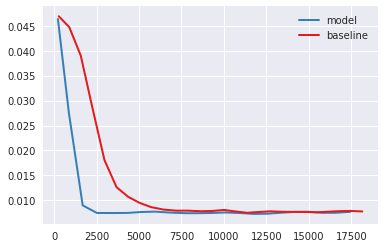

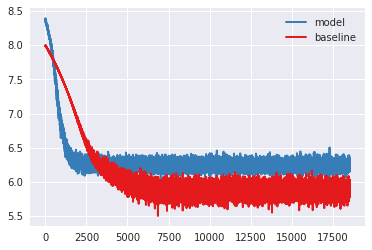

('bacteria-immune', 'Harvard Medical School')
209
498


100%|██████████| 18568/18568 [00:26<00:00, 708.84it/s]


[0.04092389769893845]


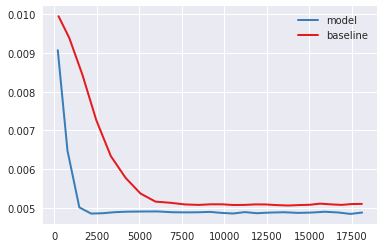

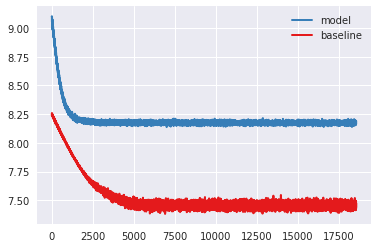

('fungi-immune', 'Harvard Medical School')
209
498


100%|██████████| 15061/15061 [00:20<00:00, 736.76it/s]


[0.010240238833086002]


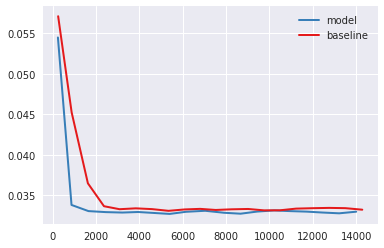

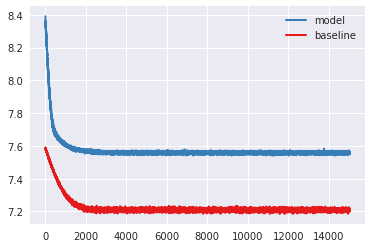

('bacteria-fungi', 'Broad Institute of MIT and Harvard')
77
1250


100%|██████████| 222629/222629 [02:59<00:00, 1236.84it/s]


[0.15637373523632303]


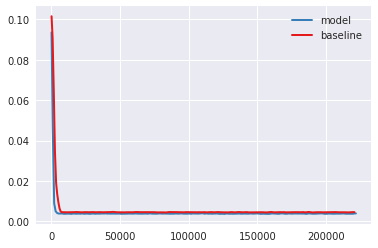

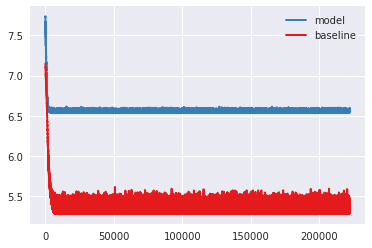

('fungi-bacteria', 'Broad Institute of MIT and Harvard')
77
1249


100%|██████████| 18880/18880 [00:27<00:00, 693.43it/s]


[0.07684334085120914]


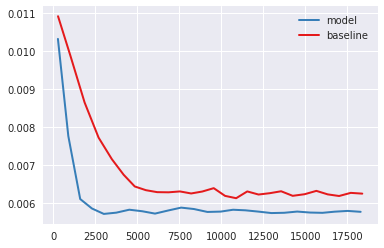

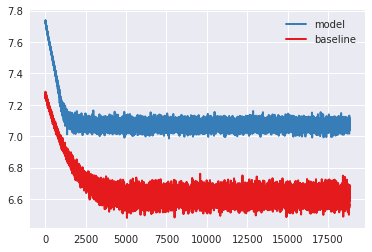

('immune-bacteria', 'Broad Institute of MIT and Harvard')
77
499


100%|██████████| 18573/18573 [00:27<00:00, 676.44it/s]


[0.051352587834988195]


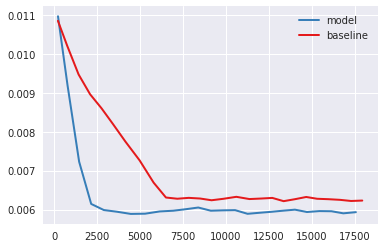

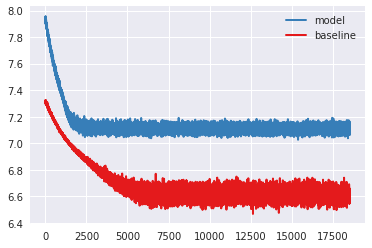

('immune-fungi', 'Broad Institute of MIT and Harvard')
77
499


100%|██████████| 18573/18573 [00:19<00:00, 969.17it/s] 


[0.14393385913847456]


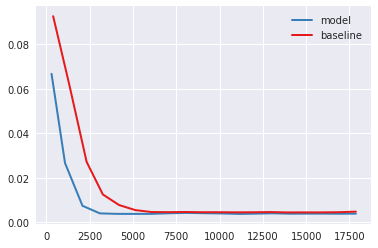

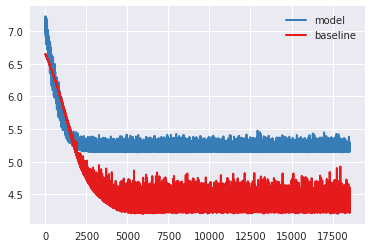

('bacteria-immune', 'Broad Institute of MIT and Harvard')
77
499


100%|██████████| 18573/18573 [00:26<00:00, 710.20it/s] 


[0.04997974041721187]


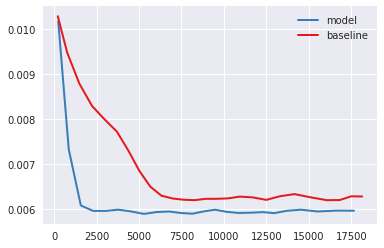

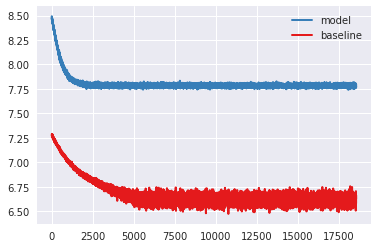

('fungi-immune', 'Broad Institute of MIT and Harvard')
77
499


100%|██████████| 7543/7543 [00:07<00:00, 958.77it/s] 


[0.09005384332460065]


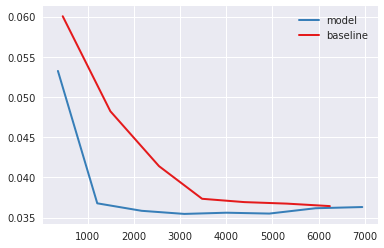

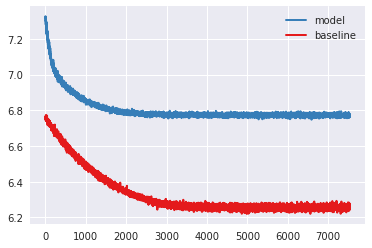

('bacteria-fungi', 'Baylor College of Medicine')
73
1241


100%|██████████| 341666/341666 [05:56<00:00, 957.34it/s] 


[0.2072006469106985]


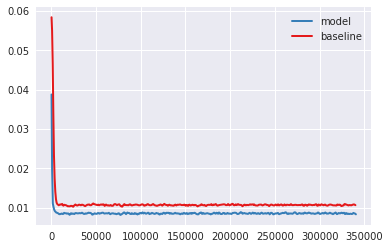

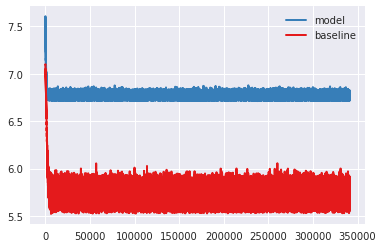

('fungi-bacteria', 'Baylor College of Medicine')
73
1241


100%|██████████| 40868/40868 [00:34<00:00, 1174.78it/s]


[0.1105438506849099]


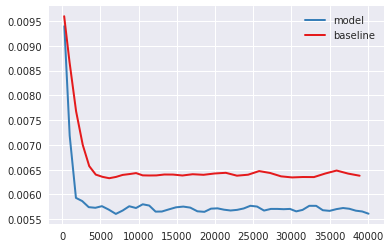

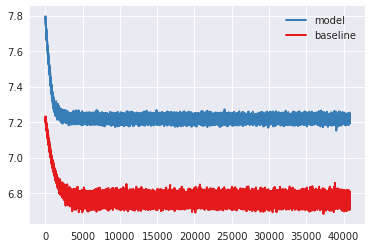

('immune-bacteria', 'Baylor College of Medicine')
73
496


100%|██████████| 17808/17808 [00:12<00:00, 1430.84it/s]


[0.05970353269544826]


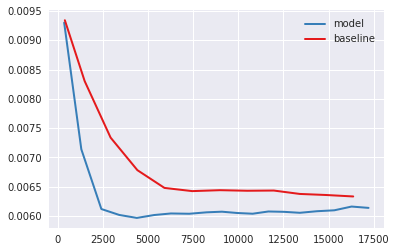

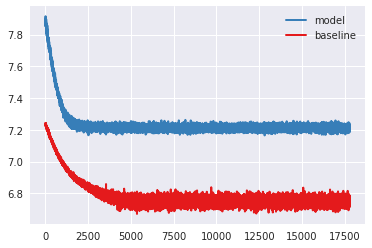

('immune-fungi', 'Baylor College of Medicine')
73
496


100%|██████████| 17808/17808 [00:14<00:00, 1227.50it/s]


[0.09464187642293131]


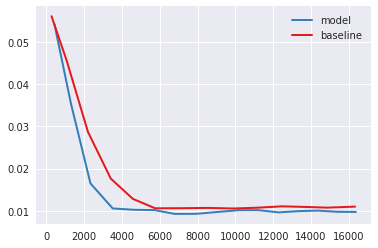

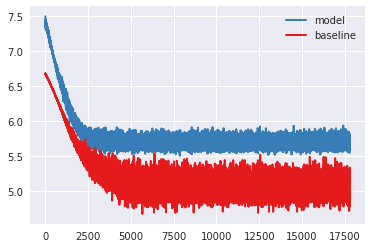

('bacteria-immune', 'Baylor College of Medicine')
73
496


100%|██████████| 17808/17808 [00:14<00:00, 1254.96it/s]


[0.05634498044094438]


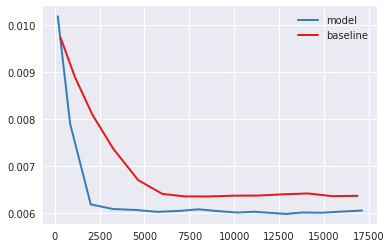

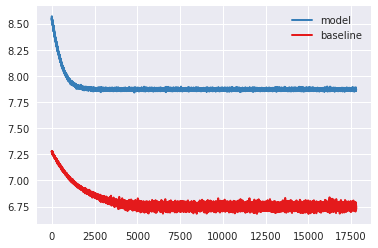

('fungi-immune', 'Baylor College of Medicine')
73
496


100%|██████████| 16334/16334 [00:15<00:00, 1054.28it/s]


[0.02083243130913426]


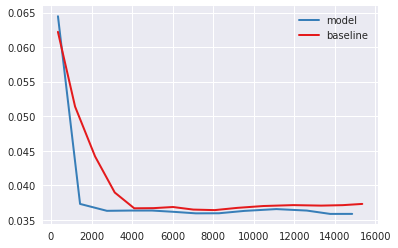

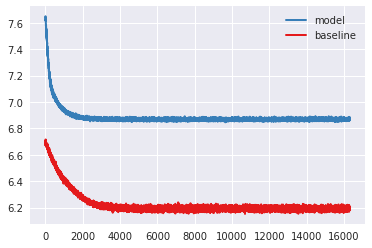

('bacteria-fungi', 'MD Anderson - Institute for Applied Cancer Science')
59
1244


100%|██████████| 116788/116788 [01:41<00:00, 1149.83it/s]


[0.1571125597406865]


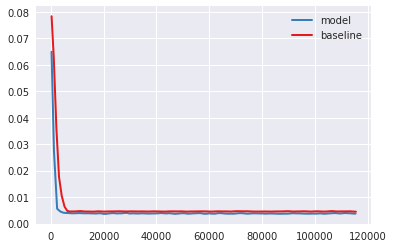

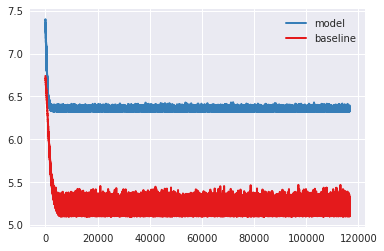

('fungi-bacteria', 'MD Anderson - Institute for Applied Cancer Science')
59
1244


100%|██████████| 26018/26018 [00:28<00:00, 902.82it/s] 


[0.13872710448674064]


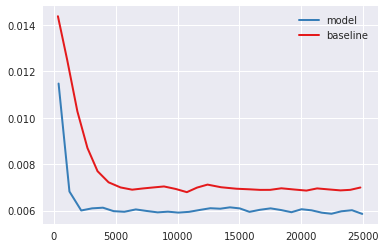

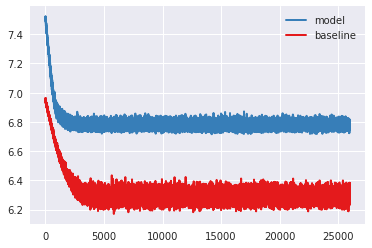

('immune-bacteria', 'MD Anderson - Institute for Applied Cancer Science')
59
497


100%|██████████| 18254/18254 [00:20<00:00, 878.42it/s] 


[0.0748820292258694]


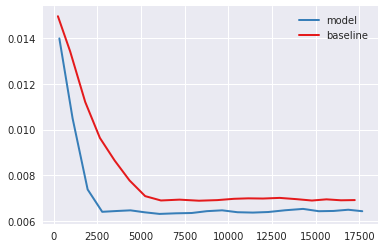

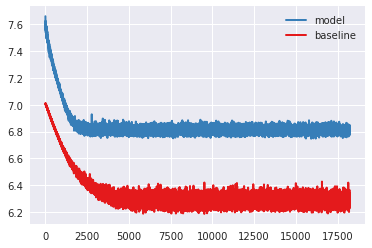

('immune-fungi', 'MD Anderson - Institute for Applied Cancer Science')
59
497


100%|██████████| 18254/18254 [00:12<00:00, 1410.30it/s]


[0.40652767109534316]


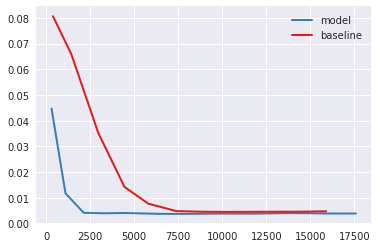

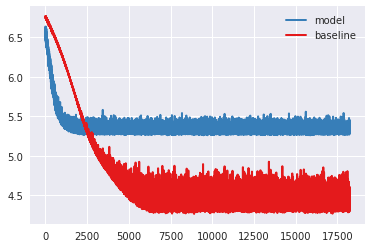

('bacteria-immune', 'MD Anderson - Institute for Applied Cancer Science')
59
497


100%|██████████| 18254/18254 [00:20<00:00, 881.65it/s] 


[0.08543913190848496]


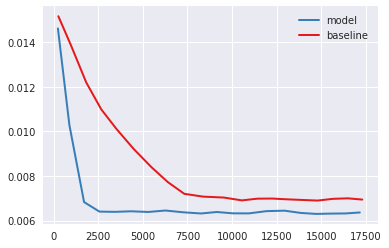

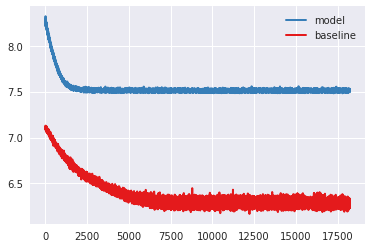

('fungi-immune', 'MD Anderson - Institute for Applied Cancer Science')
59
497


100%|██████████| 10394/10394 [00:09<00:00, 1075.77it/s]


[0.14582530754722434]


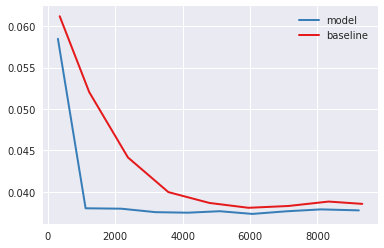

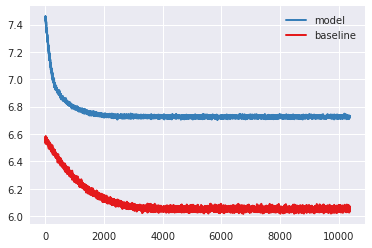

('bacteria-fungi', 'Washington University School of Medicine')
48
1237


100%|██████████| 346128/346128 [06:29<00:00, 888.93it/s] 


[0.052937996852867486]


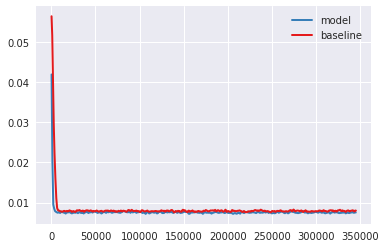

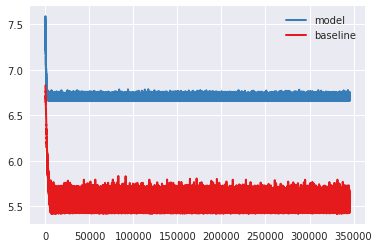

('fungi-bacteria', 'Washington University School of Medicine')
48
1237


100%|██████████| 48371/48371 [00:48<00:00, 991.70it/s] 


[0.11738074926239317]


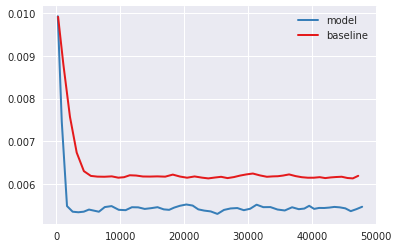

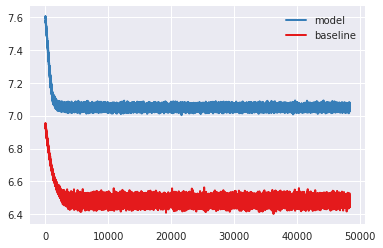

('immune-bacteria', 'Washington University School of Medicine')
48
494


100%|██████████| 17804/17804 [00:21<00:00, 811.73it/s]


[0.10188871253023013]


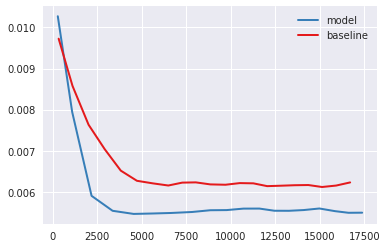

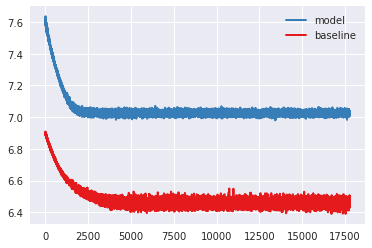

('immune-fungi', 'Washington University School of Medicine')
48
494


100%|██████████| 17804/17804 [00:17<00:00, 989.68it/s] 


[0.14338249836307793]


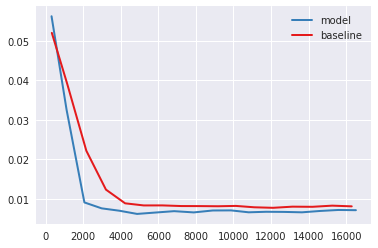

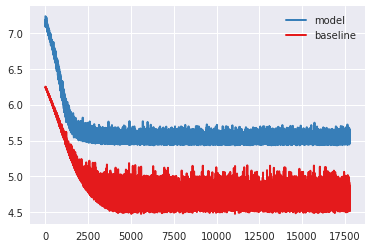

('bacteria-immune', 'Washington University School of Medicine')
48
494


100%|██████████| 17804/17804 [00:21<00:00, 830.53it/s] 


[0.10173173672033575]


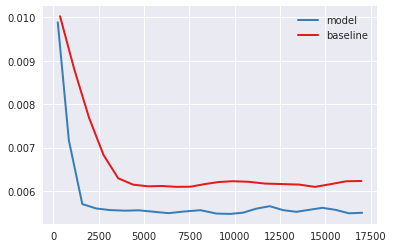

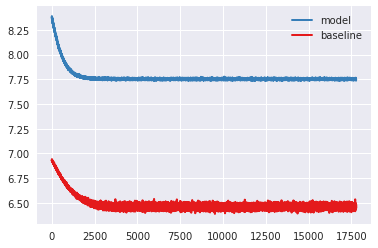

('fungi-immune', 'Washington University School of Medicine')
48
494


100%|██████████| 19317/19317 [00:19<00:00, 990.96it/s] 


[0.020299380011030377]


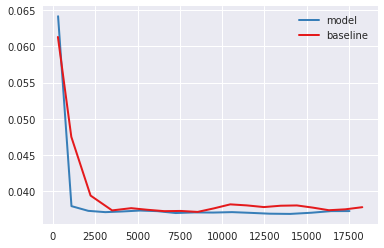

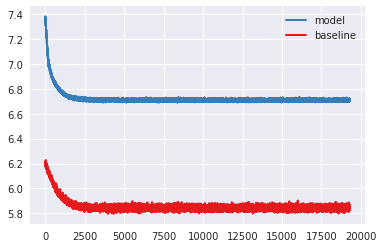

In [11]:
def retrieve_q2(model, baseline):

    # this provides a pseudo-r2 commonly provided in the context
    # of logistic / multinomail model (proposed by Cox & Snell)
    # http://www3.stat.sinica.edu.tw/statistica/oldpdf/a16n39.pdf
    end = min(10, len(model.index))
    # trim only the last 10 numbers

    # compute a q2 score, which is commonly used in
    # partial least squares for cross validation
    cv_model = model.dropna()
    cv_baseline = baseline.dropna()

    l0 = np.mean(cv_baseline['cross-validation'][-end:])
    lm = np.mean(cv_model['cross-validation'][-end:])
    q2 = 1 - lm / l0
    
    return [q2]

mmvec_results_all = {}
mmvec_q2_all = {}

latent_dim = 3

#for subset_tmp in ['Harvard Medical School', 'Baylor College of Medicine']:
for subset_tmp, (bt1tmp, bt2tmp, bt3tmp, mftmp) in data_subsets.items():

    bt1tmp, bt2tmp, bt3tmp, mftmp = data_subsets[subset_tmp]

    # import data
    metadata_tmp = Metadata(mftmp)
    # bacteria
    table_one_tmp = Artifact.import_data('FeatureTable[Frequency]', bt1tmp)
    # fungi
    table_two_tmp = Artifact.import_data('FeatureTable[Frequency]', bt2tmp)
    # immune
    table_three_tmp = Artifact.import_data('FeatureTable[Frequency]', bt3tmp)
    # save subset
    metadata_tmp.save('../results/data-subsets-genus/%s_metadata.qza' % subset_tmp.lower().replace(' ','_'))
    table_one_tmp.save('../results/data-subsets-genus/%s_bacteria_table.qza' % subset_tmp.lower().replace(' ','_'))
    table_two_tmp.save('../results/data-subsets-genus/%s_fungal_table.qza' % subset_tmp.lower().replace(' ','_'))
    table_three_tmp.save('../results/data-subsets-genus/%s_fungal_table.qza' % subset_tmp.lower().replace(' ','_'))

    # perams
    tables_order = {
                    'bacteria-fungi':[table_one_tmp, table_two_tmp],
                    'fungi-bacteria':[table_two_tmp, table_one_tmp],
                    'immune-bacteria':[table_three_tmp, table_one_tmp],
                    'immune-fungi':[table_three_tmp, table_two_tmp],
                    'bacteria-immune':[table_three_tmp, table_one_tmp],
                    'fungi-immune':[table_two_tmp, table_three_tmp]
                   }

    for mmvec_run_type, (tmptbl1, tmptbl2) in tables_order.items():
    
        if mmvec_run_type.split("-")[0] == 'immune':
            n_iterations = 2e3
            latent_dim = 3
        elif mmvec_run_type.split("-")[1] == 'immune':
            n_iterations = 2e3
            latent_dim = 10
        else:
            n_iterations = 5e3
            latent_dim = 3
        #batch_size_use = 10
        batch_size_use = int(0.25 * tmptbl1.view(Table).shape[1])
        total_microbe_reads = tmptbl1.view(Table).sum()
        epochs_use = int((n_iterations * batch_size_use) / total_microbe_reads)
        print((mmvec_run_type, subset_tmp))
        print(batch_size_use)
        print(epochs_use)
        # run MMvec
        model_res = paired_omics(tmptbl1,
                                 tmptbl2,
                                 latent_dim=latent_dim, 
                                 min_feature_count=10,
                                 epochs=epochs_use,
                                 batch_size=batch_size_use,
                                 metadata=metadata_tmp,
                                 training_column='traintest',
                                 summary_interval=1, 
                                 equalize_biplot=True)
        null_res = paired_omics(tmptbl1,
                                tmptbl2,
                                 latent_dim=0,
                                 min_feature_count=10,
                                 epochs=epochs_use,
                                 batch_size=batch_size_use,
                                 metadata=metadata_tmp,
                                 training_column='traintest',
                                 summary_interval=1, 
                                 equalize_biplot=True)
        #paired_model_stats = summarize_paired(model_res.model_stats, null_res.model_stats) 
        # save results
        model_res.conditionals.save('../results/mmvec-results-genus/%s-%s-conditionals.qza' % 
                                    (mmvec_run_type, subset_tmp.replace(' ','')))
        model_res.conditional_biplot.save('../results/mmvec-results-genus/%s-%s-conditional-biplot.qza' % 
                                          (mmvec_run_type, subset_tmp.replace(' ','')))
        #paired_model_stats.visualization.save('../results/mmvec-results/%s-%s-paired-model-stats.qzv' % 
        #                                      (mmvec_run_type, subset_tmp.replace(' ','')))
        mmvec_results_all[subset_tmp] = (model_res, null_res)
        # save just q2
        model_tmp = model_res.model_stats.view(Metadata).to_dataframe()
        baseline_tmp = null_res.model_stats.view(Metadata).to_dataframe()
        mmvec_q2_all[(mmvec_run_type, subset_tmp)] = retrieve_q2(model_tmp,
                                                                 baseline_tmp)
        print(mmvec_q2_all[(mmvec_run_type, subset_tmp)])
        model_tmp_cv = model_tmp.dropna().rolling(2).mean().dropna().reset_index()
        baseline_tmp_cv = baseline_tmp.dropna().rolling(2).mean().dropna().reset_index()
        plt.plot(model_tmp_cv.dropna()['iteration'], model_tmp_cv.dropna()['cross-validation'], label='model', c='#377eb8', lw=2)
        plt.plot(baseline_tmp_cv.dropna()['iteration'], baseline_tmp_cv.dropna()['cross-validation'], label='baseline', c='#e41a1c', lw=2)
        plt.legend()
        plt.show()

        plt.plot(model_tmp['iteration'], np.log(model_tmp['loss']),
                 label='model', c='#377eb8', lw=2)
        plt.plot(baseline_tmp['iteration'], np.log(baseline_tmp['loss']),
                 label='baseline', c='#e41a1c', lw=2)
        plt.legend()
        plt.show()




In [12]:
mmvec_q2_all_df = pd.DataFrame(mmvec_q2_all, ['Q-squared']).T
mmvec_q2_all_df.to_csv('../results/tables/mmvec-results-genus/all-mmvec-runs-q-squareds.csv')
mmvec_q2_all_df


,,Q-squared
bacteria-fungi,Harvard Medical School,0.388033
fungi-bacteria,Harvard Medical School,0.147967
immune-bacteria,Harvard Medical School,0.040475
immune-fungi,Harvard Medical School,0.026234
bacteria-immune,Harvard Medical School,0.040924
fungi-immune,Harvard Medical School,0.010240
bacteria-fungi,Broad Institute of MIT and Harvard,0.156374
fungi-bacteria,Broad Institute of MIT and Harvard,0.076843
immune-bacteria,Broad Institute of MIT and Harvard,0.051353
immune-fungi,Broad Institute of MIT and Harvard,0.143934
